## Import Libraries

In [ ]:
# !pip install 'umap-learn==0.3.10'

In [64]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import zscore
from sklearn.decomposition import PCA
# from umap import UMAP


from scipy.stats import pearsonr
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

import random

from tqdm import tqdm

from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt



## Load Stringer Data

In [2]:
#@title Data retrieval
import os, requests

fname = "stringer_orientations.npy"
url = "https://osf.io/ny4ut/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [3]:
dat = np.load('stringer_orientations.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'istim', 'stat', 'u_spont', 'v_spont', 'mean_spont', 'std_spont', 'stimtimes', 'frametimes', 'camtimes', 'run', 'info', 'xyz'])


dat has fields:
* `dat['sresp']`: neurons by stimuli, a.k.a. the neural response data (23589 neurons by 4598 time points)
* `dat['xyz']`: three-dimensional position of each neuron in the brain. 
* `dat['run']`: 1 by stimuli, a.k.a. the running speed of the animal in a.u.
* `dat['istim']`: 1 by stimuli, goes from 0 to 2*np.pi, the orientations shown on each trial
* `dat['u_spont']`: neurons by 128, the weights for the top 128 principal components of spontaneous activity. Unit norm.
* `dat['v_spont']`: 128 by 910, the timecourses for the top 128 PCs of spont activity.
* `dat['u_spont'] @ dat['v_spont']`: a reconstruction of the spontaneous activity for 910 timepoints interspersed throughout the recording.
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.


## Find correlations between variables

In [ ]:
corr, p = pearsonr(dat['istim'], dat['run'])
# display the correlation
print(corr)
print('Pearsons correlation: %.3f' % corr)

-0.034845151696693284
Pearsons correlation: -0.035


In [ ]:
#id=2000
ids=[]
s=0
for id in range(0,23589):
  corr, p = pearsonr(dat['sresp'][id], dat['run'])
  s+=corr
  

print(s/23589)
# display the correlation
#print('Pearsons correlation: %.3f' % corr)

0.10016815846029269


In [ ]:
s2=0
for id in range(0,23589):
  corr, p = pearsonr(dat['sresp'][id], dat['istim'])
  s2+=corr
print(s/23589)
 
#print('Pearsons correlation: %.3f' % corr)

0.10016815846029269


## Logistic Regression Model

In [50]:
def binarize_y (y:np.array, cutoff:int):
  "convert an 1-D array to binary: if > cutoff, then 1, otherwise 0"

  y_binarized = np.where(y <= cutoff, 0, 1)
  return y_binarized


def log_regression_model (cutoff:int, solver:str='liblinear' , penalty:str = "l2", X=dat['sresp'], y=dat['run'], train_test_split:int = 3800, verbose:bool=True):

  X = X.T
  y = binarize_y (y, cutoff)

  X_train=X[:train_test_split]
  y_train=y[:train_test_split]
  X_test=X[train_test_split:]
  y_test=y[train_test_split:]

  logreg_model = LogisticRegression(random_state=0, solver = solver, penalty = penalty).fit(X_train, y_train)
  y_predicted = logreg_model.predict(X_test)
  accuracy_logreg_model = np.mean(y_predicted == y_test)

  if verbose == True:
    print(f"The accuracy of our LR model(with the cutoff for binarizing speed = {cutoff}, solver = {solver}, and penalty = {penalty}) is {accuracy_logreg_model}")

  return logreg_model, accuracy_logreg_model

#### First we try a LR model by binarizing the speed using the following logic:

- zero speed = 0
- non-zero speed = 1

In [24]:
_,_ = log_regression_model (cutoff=0)

The accuracy of our LR model(with the cutoff for binarizing speed = 0 and solver = liblinear) 
 is 0.8734335839598998


#### Following that, we try to find a more logically appropriate cut-off of stationary/running by running a for-loop.

In [ ]:
# Create a dictionary to store the accuracies of LR model for different cutoffs

accuracies_logreg_across_diff_cutoffs = {} 

# Initiate a for-loop

for i_cutoff in tqdm(range(0,40,2)):

  _, accuracy_temp = log_regression_model (i_cutoff, verbose=False)

  accuracies_logreg_across_diff_cutoffs[i_cutoff] = accuracy_temp

Text(0, 0.5, 'accuracy of LR')

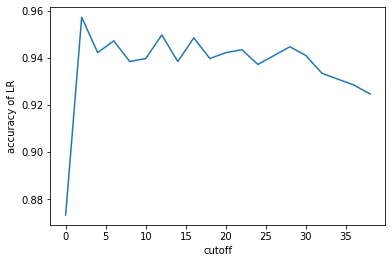

In [8]:
plt.plot(list(accuracies_logreg_across_diff_cutoffs.keys()), list(accuracies_logreg_across_diff_cutoffs.values()))
plt.xlabel("cutoff for binarizing speed")
plt.ylabel("accuracy of LR model")

#### We see that choosing the cut-off to be 2 will be the most optimum. We finalize our LR model.

In [25]:
logreg_l2, _ = log_regression_model (cutoff=2)

The accuracy of our LR model(with the cutoff for binarizing speed = 2 and solver = liblinear) 
 is 0.9573934837092731


#### We find out the significant neurons for speed prediction

significant weights are considered the ones beyond 3sigma


(-0.01, 0.01)

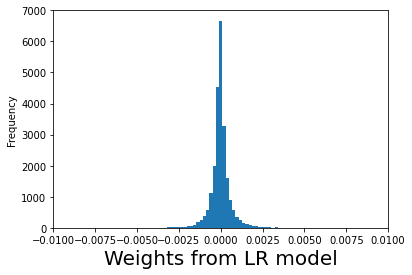

In [26]:
plt.hist(logreg_l2.coef_[0], bins=50)
plt.xlabel('Weights from LR model',size=20)
plt.ylabel('Frequency')
plt.xlim(-0.01,0.01)

In [57]:
def plot_significant_neurons (model, sigma_cutoff:int):


  cutoff = model.coef_[0].std()*sigma_cutoff

  sig_coef_idx = []

  for idx, element in enumerate(model.coef_[0]):
    if abs(element) > cutoff:
      sig_coef_idx.append(idx)

  print(f"Out of {len(model.coef_[0])} weights, {len(sig_coef_idx)} are siignificant with a {sigma_cutoff}-sigma cutoff")

  x, y, z = dat['xyz']
  z2 = z[sig_coef_idx]

  plt.hist(z, bins=25, density=True)
  plt.xlabel('Z position of all neurons', size=15)
  plt.ylabel('Frequency (normalized)', size=15)
  plt.figure()

  plt.hist(z2,bins=25)
  plt.xlabel(f'Z position of significant neurons ({sigma_cutoff}-sigma)', size=15)
  plt.ylabel('Frequency (normalized)', size=15)

Out of 23589 weights, 1387 are siignificant with a 2-sigma cutoff


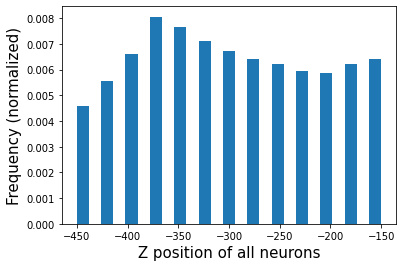

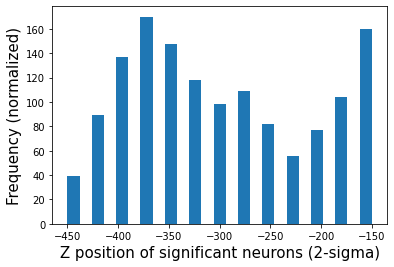

In [58]:
plot_significant_neurons (logreg_l2, sigma_cutoff=2)

Out of 23589 weights, 4459 are siignificant with a 1-sigma cutoff


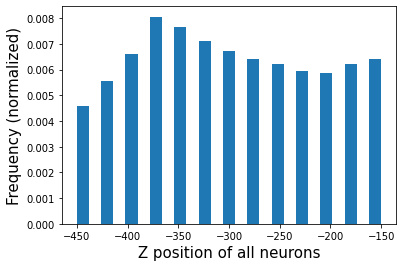

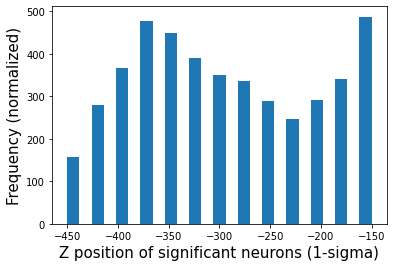

In [59]:
plot_significant_neurons (logreg_l2, sigma_cutoff=1)

#### The default regularization is L2 for sklearn LR. 
Let's try the same analysis with L1.

In [51]:
logreg_l1, _ = log_regression_model (cutoff=2, penalty = 'l1', verbose=True)

The accuracy of our LR model(with the cutoff for binarizing speed = 2, solver = liblinear, and penalty = l1) is 0.9548872180451128


(-0.01, 0.01)

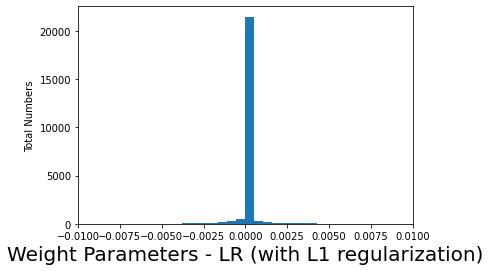

In [63]:
plt.hist(logreg_l1.coef_[0], bins=50)
plt.xlabel('Weight Parameters - LR (with L1 regularization)',size=20)
plt.ylabel('Total Numbers')
plt.xlim(-0.01,0.01)

Out of 23589 weights, 921 are siignificant with a 2-sigma cutoff


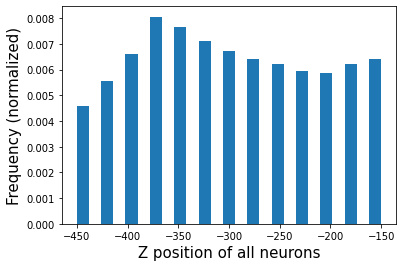

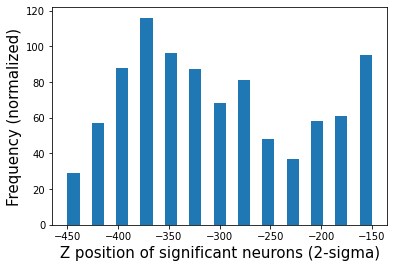

In [60]:
plot_significant_neurons (logreg_l1, sigma_cutoff=2)

Out of 23589 weights, 1510 are siignificant with a 1-sigma cutoff


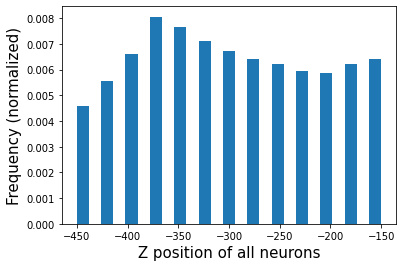

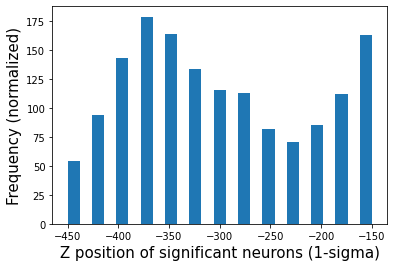

In [62]:
plot_significant_neurons (logreg_l1, sigma_cutoff=1)

## Linear Regression Model (GLM)

In [78]:
def linear_regression_model (model, penalty:str, X=dat['sresp'], y=dat['run'], train_test_split:int = 3800, verbose:bool=True, plot_regular:bool=False, plot_correlation:bool=False):

    X = X.T

    X_train=X[:train_test_split]
    y_train=y[:train_test_split]
    X_test=X[train_test_split:]
    y_test=y[train_test_split:]

    model = model.fit(X_train, y_train)
    y_predicted = model.predict(X_test)

    mse_error = np.sqrt(mean_squared_error(y_test, y_predicted))
    r2 = r2_score(y_test, y_predicted)
    
    if verbose == True:
          print(f"This Linear regression model (with penalty = {penalty}) is able to predict the speed with MSE ={mse_error} and r2_score = {r2}.")

    if plot_regular == True:

      t = np.linspace(0,100,len(y_test))

      plt.scatter(t, y_test,label='test data')
      plt.scatter(t, y_predicted, label='predicted output')
      plt.legend()
      plt.xlabel('time',size=20)
      plt.ylabel('running speed',size=20)
      plt.figure()

    if plot_correlation == True:

      corr = np.corrcoef(y_test, y_predicted)[0][1]

      y_test_aug = np.vstack((np.ones_like(y_test.T), y_test.T)).T
      theta = np.linalg.inv(y_test_aug.T.dot(y_test_aug)).dot(y_test_aug.T).dot(y_predicted)

      plt.xlim(0,100)
      plt.scatter(y_test, y_predicted)
      plt.legend()
      plt.xlabel('test data (running speed)',size=20)
      plt.ylabel('predicted output (running speed)',size=20)

      y_line = y_test_aug.dot(theta)
      plt.plot(y_test, y_line, 'cyan', linewidth=5)

      plt.figure()


    # return model, mse_error, r2

#### Cross-validate the model

In [71]:
def lets_do_crossval (model, fold:int, X=dat['sresp'], y=dat['run']):

  X = X.T
  
  accuracies_crossval = cross_val_score(model, X, y, cv=fold)  

  f, ax = plt.subplots(figsize=(8, 3))
  ax.boxplot(accuracies_crossval, vert=False, widths=.7)
  ax.scatter(accuracies_crossval, np.ones(8))
  ax.axis(xmin=0.65,xmax=0.90)
  ax.set(
    xlabel="Accuracy",
      yticks=[],
        title=f"Average test accuracy for Linear regression : {accuracies_crossval.mean():.2%}"
        )
  ax.spines["left"].set_visible(False)
  ax.spines["right"].set_visible(False)
  ax.spines["top"].set_visible(False)

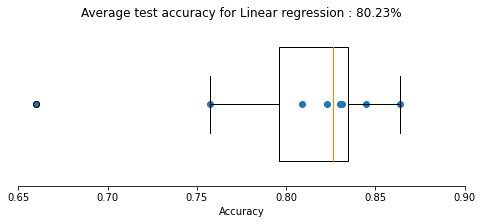

In [72]:
lets_do_crossval (model= LinearRegression(), fold=8)

### Implement different Linear Regression models (with different regularizations)

**Linear Regression Model 1 (GLM with No regularization)**


This Linear regression model (with penalty = None) is able to predict the speed with MSE =9.079253611733689 and r2_score = 0.8259746974015528.


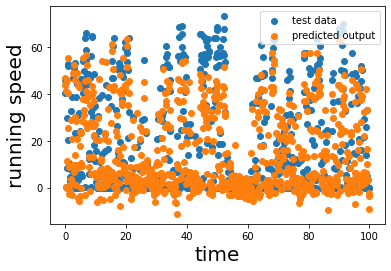

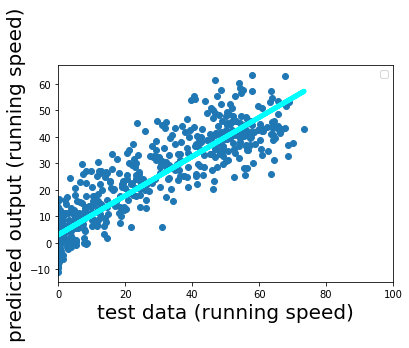

<Figure size 432x288 with 0 Axes>

In [79]:
linreg_default = LinearRegression()

linear_regression_model (model= linreg_default, penalty='None', plot_regular=True, plot_correlation=True)

**Linear Regression Model 2 (GLM with L2 regularization)**

In [80]:
#Ridge Regression
#Loss function = OLS + alpha * summation (squared coefficient values)
#Ridge regression addresses some of the problems of Ordinary Least Squares by imposing a penalty on the size of the coefficients with l2 regularization.

linreg_l2 = Ridge(alpha=0.01)
linear_regression_model (model= linreg_l2, penalty='Ridge (L2)')

This Linear regression model (with penalty = Ridge (L2)) is able to predict the speed with MSE =9.079253606398959 and r2_score = 0.8259746976060581.


**Linear Regression Model 3 (GLM with L1 regularization)**

In [81]:
#Lasso Regression
#The Lasso is a linear model that estimates sparse coefficients with l1 regularization.
#Loss function = OLS + alpha * summation (absolute values of the magnitude of the coefficients)

linreg_l1 = Lasso(alpha=0.01)
linear_regression_model (model= linreg_l1, penalty='Lasso (L1)')

This Linear regression model (with penalty = Lasso (L1)) is able to predict the speed with MSE =11.145053357305118 and r2_score = 0.7377736036419446.


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.861e+02, tolerance: 1.206e+02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


**Linear Regression Model 4 (GLM with L1 and L2 regularization)**

In [82]:
#Elastic Net
#Elastic-Net is a linear regression model trained with both l1 and l2 -norm regularization of the coefficients.

linreg_l1_l2 = ElasticNet(alpha = 0.01)
linear_regression_model (model= linreg_l1_l2, penalty='Elastic Net (both L1 & L2)')

This Linear regression model (with penalty = Elastic Net (both L1 & L2)) is able to predict the speed with MSE =12.86504522910396 and r2_score = 0.6505904769018258.


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.888e+02, tolerance: 1.206e+02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


**Results of the models GLM Linear regression**

---



**Linear Regression** Model **No regularisation** : Test set RMSE of 9.08 thousand and R-square of 82.6 percent.

**Ridge Regression Model L2**: Test set RMSE of 9.08 thousand and R-square of 82.6 percent.

**Lasso Regression Model_L1**: Test set RMSE of 12.86 thousand and R-square of 73.78 percent.

**ElasticNet Regression Model L1 and L2**: Test set RMSE of 12.86 thousand and R-square of 65.06 percent.






## Preliminary data exloration & PCA (that was provided by Neuromatch)

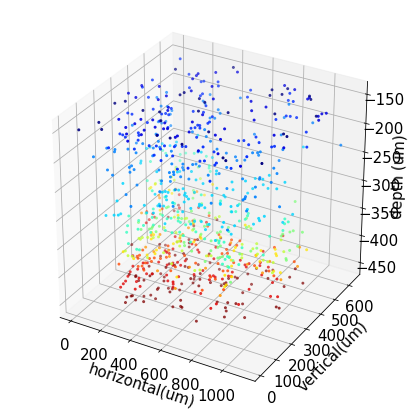

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y, z = dat['xyz']

x = x[sig_coef_idx]
y = y[sig_coef_idx]
z = z[sig_coef_idx]

zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('jet')(xc)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1], y[::-1], z[::-1], 'o', s=4, c=cmap[iunq])
ax.set(xlabel='horizontal(um)', ylabel='vertical(um)', zlabel='depth (um)')
plt.show()


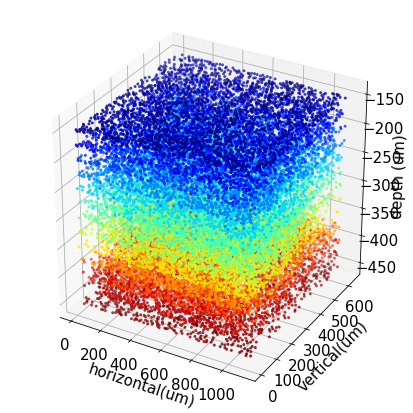

In [ ]:
# @title plot the 3D positions of all neurons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y, z = dat['xyz']

zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('jet')(xc)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1], y[::-1], z[::-1], 'o', s=4, c=cmap[iunq])
ax.set(xlabel='horizontal(um)', ylabel='vertical(um)', zlabel='depth (um)')
plt.show()

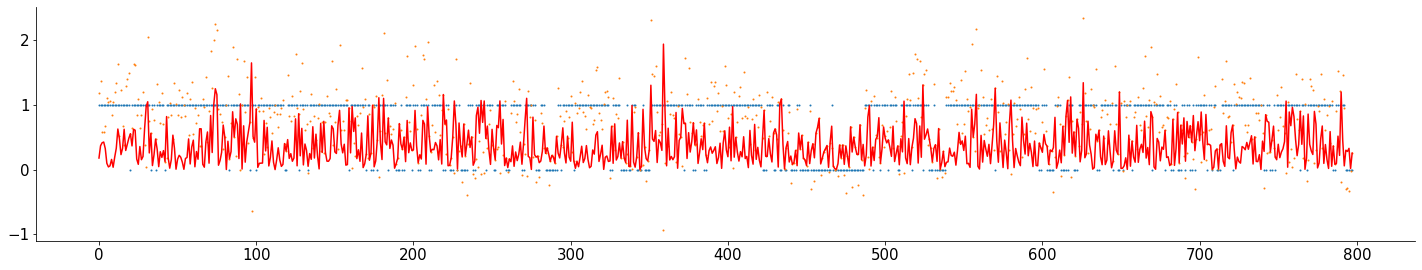

the difference between real and predicted is less then .5 with ratio:  0.7243107769423559


In [ ]:
# let us plot the prediction and the actual value, for comparison

plt.scatter([range(0,798)] ,y_test, label='true', s= 1)

plt.scatter([range(0,798)],prediction, label='predicted', s= 1)

plt.plot(abs(y_test - prediction), label='difference', c='r' )

plt.show()

accuracy3 = np.mean(abs(y_test - prediction) < .5)

print('the difference between real and predicted is less then .5 with ratio: ', accuracy3)

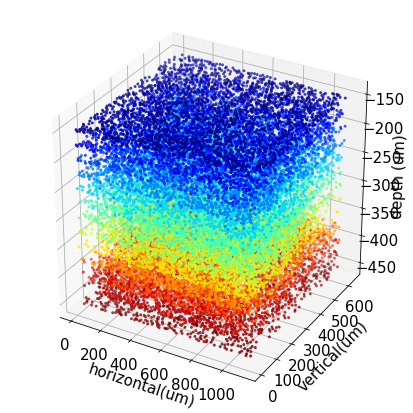

In [ ]:
# @title plot the 3D positions of all neurons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y, z = dat['xyz']

zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('jet')(xc)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1], y[::-1], z[::-1], 'o', s=4, c=cmap[iunq])
ax.set(xlabel='horizontal(um)', ylabel='vertical(um)', zlabel='depth (um)')
plt.show()

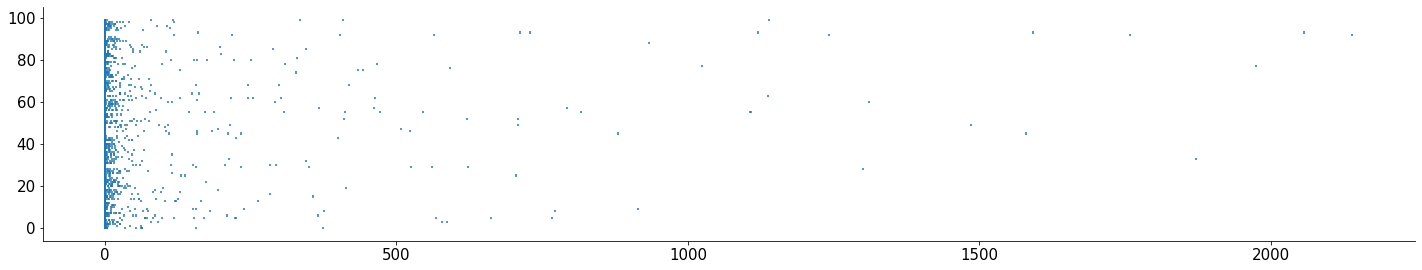

In [ ]:
plt.eventplot(dat['sresp'][:100, :200])
plt.show()

We have three kinds of neurons:

- unimodal tuning
- bimodal tuning
- silent/flat

[Text(0, 0.5, '(n=1500)th neural tuning'), Text(0.5, 0, 'orientation')]

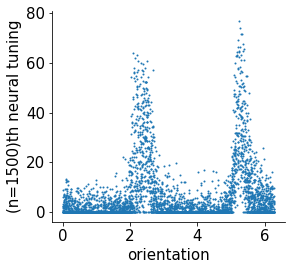

In [ ]:
ax = plt.subplot(1, 5, 2)
id = 1500
plt.scatter(dat['istim'], dat['sresp'][id], s=1)
ax.set(xlabel='orientation', ylabel=f'(n={id})th neural tuning')

(array([1.2768e+04, 5.3470e+03, 2.5330e+03, 1.3820e+03, 7.3900e+02,
        4.1400e+02, 2.5200e+02, 1.0500e+02, 4.3000e+01, 6.0000e+00]),
 array([  10.37379932,  295.80907564,  581.24435196,  866.67962828,
        1152.11490459, 1437.55018091, 1722.98545723, 2008.42073355,
        2293.85600986, 2579.29128618, 2864.7265625 ]),
 <a list of 10 Patch objects>)

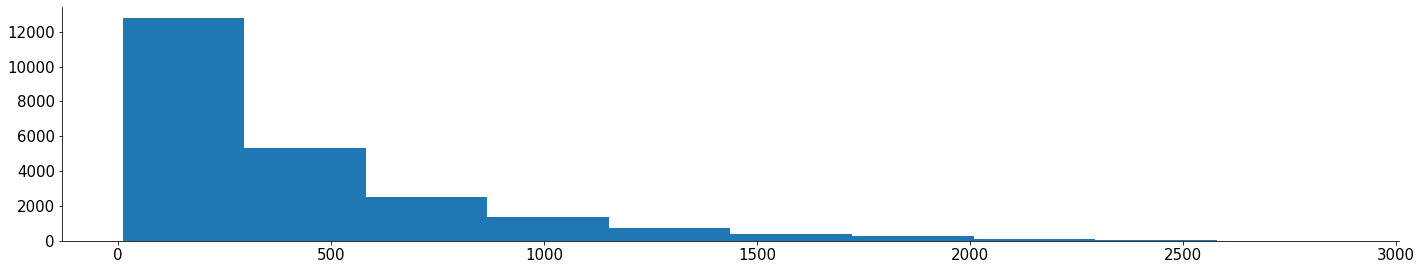

In [ ]:
cutoff = 1000
li = []
for ix_neuron in range(dat['sresp'].shape[0]):
  # print(dat['sresp'][ix_neuron].max())
  li.append(dat['sresp'][ix_neuron].max())

#   if dat['sresp'][ix_neuron].max() > cutoff:
#       li.append(ix_neuron)
# print(len(li))

plt.hist(li)

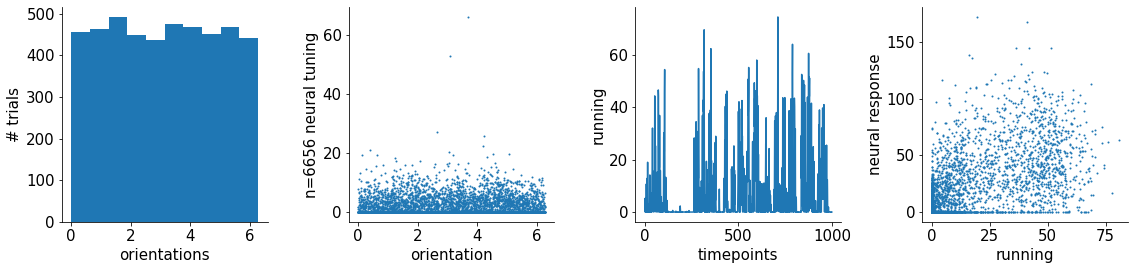

In [ ]:
# @title Basic data properties using plot, hist and scatter
ax = plt.subplot(1, 5, 1)
plt.hist(dat['istim'])
ax.set(xlabel='orientations', ylabel='# trials')

ax = plt.subplot(1, 5, 2)
id = 6656
plt.scatter(dat['istim'], dat['sresp'][id], s=1)
ax.set(xlabel='orientation', ylabel=f'n={id} neural tuning')

ax = plt.subplot(1, 5, 3)
plt.plot(dat['run'][:1000])
ax.set(xlabel='timepoints', ylabel='running')

ax = plt.subplot(1, 5, 4)
plt.scatter(dat['run'], dat['sresp'][20998], s=1)
ax.set(xlabel='running', ylabel='neural response')

plt.show()

In [ ]:
X=dat['sresp'].shape()
Y=dat['run'].shape()

TypeError: ignored

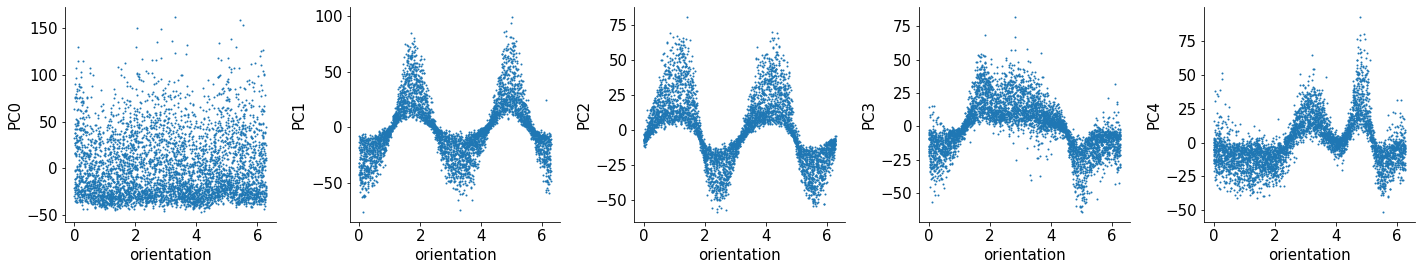

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


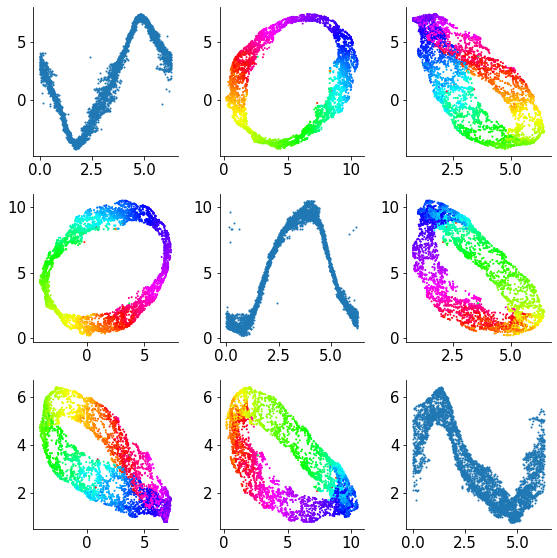

In [ ]:
plt.figure(figsize=(8,8))
for i in range(ncomp):
  for j in range(ncomp):
    plt.subplot(ncomp,ncomp, j + ncomp*i + 1)
    if i == j:
      plt.scatter(dat['istim'], embed[:, i], s=1)
    else:
      plt.scatter(embed[:, j], embed[:, i], s=1, c=dat['istim'], cmap='hsv')
plt.show()

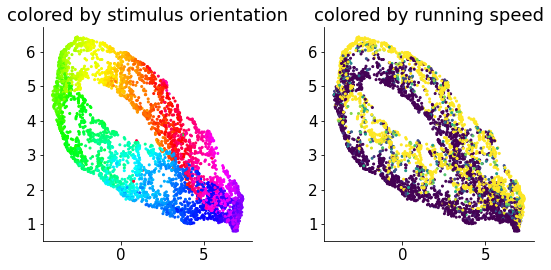

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.scatter(embed[:, 0], embed[:, 2], s=4, c=dat['istim'], cmap='hsv')
plt.title('colored by stimulus orientation')

plt.subplot(1, 2, 2)
plt.scatter(embed[:, 0], embed[:, 2], s=4, c=dat['run'], vmin=0, vmax=10)
plt.title('colored by running speed')
plt.show()